In [3]:
"""
Script written by Andrew Rohne. This prepares updates the joint tour model for Met Council

Needs: 
  1: Visualizer Survey folder - reads one of the CSVs
  2: ActivitySim tours output

How To Use:
  1: Set the project_dir (cell 2) to the base of your project - this should include the visualizer summary inputs and the model data
  2: Set the output folder (where some CSV files are saved)
  2: Fix the census_auto_ownership_file (text should be relative to project_dir)
  3: Fix the hh file (again, should be relative to project_dir)
  4: You'll probably need to update some fields
  

"""
import sys
import pandas as pd
import os
import numpy as np
pd.options.display.max_columns = 50
pd.options.display.max_rows = 500
 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

ASIM_OUTPUT = r"E:\Met_Council\metc-asim-model\Base_2018\activitysim\output"
ASIM_CONFIGS_PATH = r'E:\Met_Council\metc-asim-model\source\activitysim\configs'
SURVEY_SUMMARY_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\base'
SYNPOP_INPUT = r'E:\Met_Council\metc-asim-model\Input\socioeconomic'
SURVEY_PATH = r'E:\Met_Council\survey_data\Phase1\SPA_Inputs'
CENSUS_SUMMARY_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\census'

SAMPLE_RATE = 0.20767

PERTYPEMAP = {1: 'FT', 2: 'PT', 3: 'U', 4: 'NW', 5: 'R', 6: 'SD', 7: 'SPD', 8: 'PS'}

Vis = {"No Joint Tours": 1, "1 Shopping": 2, "1 Maintenance": 3, "1 Eating Out": 4, "1 Visiting": 5, 
         "1 Other Discretionary": 6, "2 Shopping": 7, "1 Shopping / 1 Maintenance": 8, "1 Shopping / 1 Eating Out": 9, 
         "1 Shopping / 1 Visiting": 10, "1 Shopping / 1 Other Discretionary": 11, "2 Maintenance": 12, 
         "1 Maintenance / 1 Eating Out": 13, "1 Maintenance / 1 Visiting": 14, "1 Maintenance / 1 Other Discretionary": 15, 
         "2 Eating Out": 16, "1 Eating Out / 1 Visiting": 17, "1 Eating Out / 1 Other Discretionary": 18, 
         "2 Visiting": 19, "1 Visiting / 1 Other Discretionary": 20, "2 Other Discretionary": 21}


Vis_Mod = {1: '0_tours', 2: '1_Shop', 3: '1_Main', 4: '1_Eat', 5: '1_Visit', 6: '1_Disc', 7: '2_SS', 8: '2_SM', 9: '2_SE',
           10: '2_SV', 11: '2_SD', 12: '2_MM', 13: '2_ME', 14: '2_MV', 15: '2_MD', 16: '2_EE', 17: '2_EV', 18: '2_ED',
           19: '2_VV', 20: '2_VD', 21: '2_DD'}

Calib_Line = {'coef_asc_0_tours': '0_tours', 'coef_asc_1_Shop': '1_Shop', 'coef_asc_1_Main': '1_Main', 
              'coef_asc_1_Eat': '1_Eat', 'coef_asc_1_Visit': '1_Visit', 'coef_asc_1_Disc': '1_Disc', 
              'asc_calib_2_SS': '2_SS', 'asc_calib_2_SM': '2_SM', 'asc_calib_2_SE': '2_SE', 'asc_calib_2_SV': '2_SV', 
              'asc_calib_2_SD': '2_SD', 'asc_calib_2_MM': '2_MM', 'asc_calib_2_ME': '2_ME', 'asc_calib_2_MV': '2_MV', 
              'asc_calib_2_MD': '2_MD', 'asc_calib_2_EE': '2_EE', 'asc_calib_2_EV': '2_EV', 'asc_calib_2_ED': '2_ED', 
              'asc_calib_2_VV': '2_VV', 'asc_calib_2_VD': '2_VD', 'asc_calib_2_DD': '2_DD'}

modJtf_in = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_households.csv"))
obsJtf = pd.read_csv(os.path.join(SURVEY_SUMMARY_PATH, "jtf.csv")).rename(columns = {'freq': 'ObsN'})
#obsJtf = obsJtf[obsJtf['jtf_code'] != 1]
asim_config = pd.read_csv(os.path.join(ASIM_CONFIGS_PATH, "joint_tour_frequency_coefficients.csv"))

In [4]:
modJtf = modJtf_in.groupby('joint_tour_frequency').agg(ModN = ('household_id', 'count')).reset_index()
modJtf['ModN'] = modJtf['ModN'] / SAMPLE_RATE
#modJtf = modJtf[modJtf['joint_tour_frequency'] != '0_tours']
modJtf['ModPct'] = modJtf['ModN'] / modJtf['ModN'].sum()

obsJtf['ObsPct'] = obsJtf['ObsN'] / obsJtf['ObsN'].sum()
obsJtf['jtfPurp'] = obsJtf['jtf_code'].map(Vis_Mod)

asim_config['jtfPurp'] = asim_config['coefficient_name'].map(Calib_Line)

jtfComp = modJtf.merge(obsJtf, left_on = 'joint_tour_frequency', right_on = 'jtfPurp').merge(asim_config, left_on = 'jtfPurp', right_on = 'jtfPurp')
jtfComp['coef_adj'] = np.log(jtfComp['ObsPct'] / jtfComp['ModPct'], where=jtfComp['ObsPct']>0)
jtfComp['new_coef'] = np.round(jtfComp['value'] + jtfComp['coef_adj'],4)

jtfo = jtfComp[['joint_tour_frequency', 'ObsN', 'ModN', 'ObsPct', 'ModPct', 'value', 'coef_adj', 'new_coef']]
jtfo.style.format(formatter = {'ObsN': "{:,.0f}", 'ModN': "{:,.0f}", 'ModPct': "{:.2%}".format, 'ObsPct': "{:.2%}".format})

,joint_tour_frequency,ObsN,ModN,ObsPct,ModPct,value,coef_adj,new_coef
0,0_tours,"1,145,459","1,153,792",79.29%,79.87%,4.413900,-0.007238,4.406700
1,1_Disc,40,29,0.00%,0.00%,-7.436100,0.323269,-7.112800
2,1_Eat,"27,983","27,760",1.94%,1.92%,-0.793900,0.008002,-0.785900
3,1_Main,"64,170","62,373",4.44%,4.32%,0.302500,0.028410,0.330900
4,1_Shop,"51,439","49,901",3.56%,3.45%,-0.099100,0.030368,-0.068700
5,1_Visit,"45,947","44,368",3.18%,3.07%,0.147500,0.034970,0.182500
6,2_DD,0,39,0.00%,0.00%,-10.000000,0.000000,-10.000000
7,2_ED,0,10,0.00%,0.00%,-10.000000,0.000000,-10.000000
8,2_EE,"14,164","13,473",0.98%,0.93%,-4.148200,0.050031,-4.098200
9,2_EV,"15,932","15,462",1.10%,1.07%,-3.584900,0.029937,-3.555000


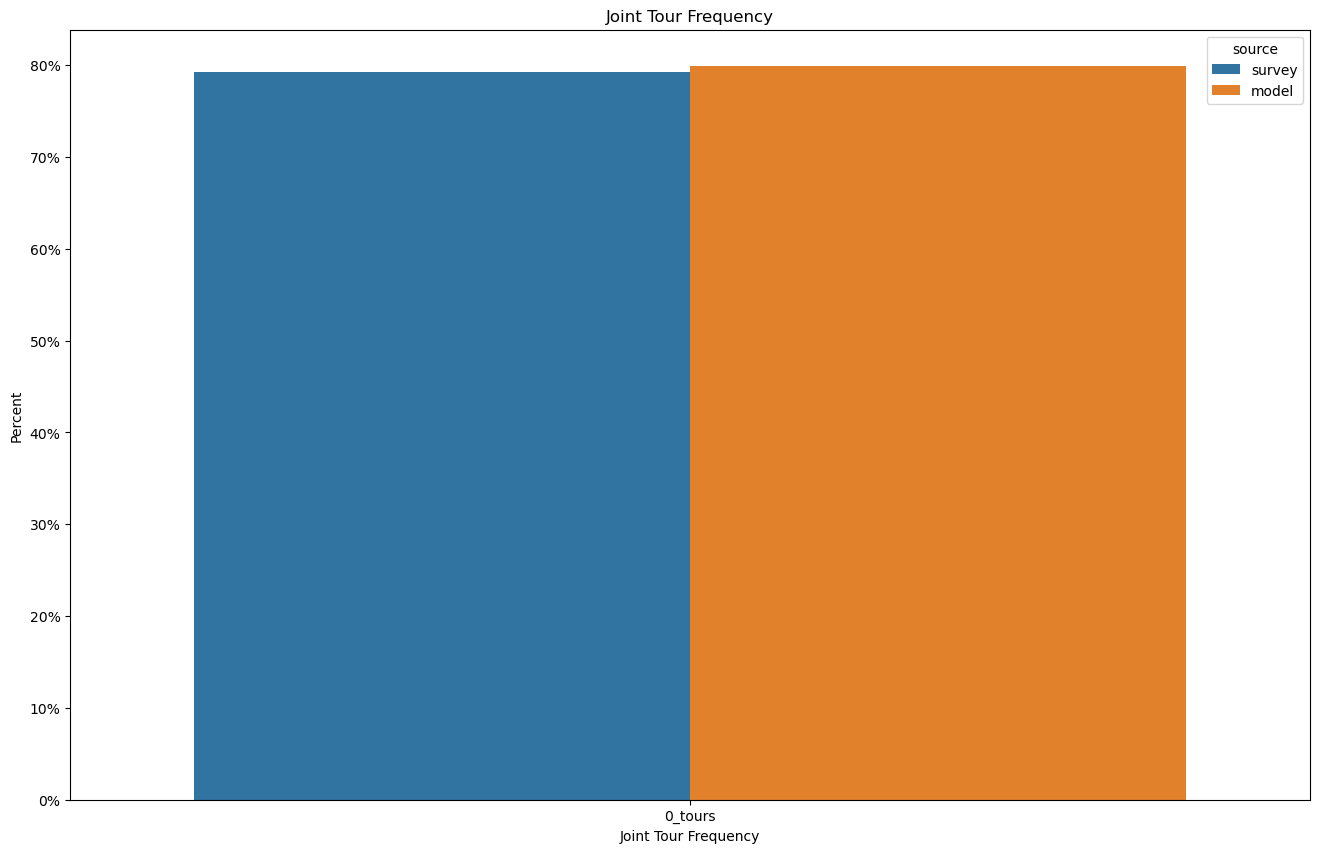

In [5]:
plot_data = pd.concat([jtfo[jtfo['joint_tour_frequency'] == '0_tours'][['joint_tour_frequency', 'ObsPct']].rename(columns = {'ObsPct': 'percent'}).assign(source = 'survey'),
    jtfo[jtfo['joint_tour_frequency'] == '0_tours'][['joint_tour_frequency', 'ModPct']].rename(columns = {'ModPct': 'percent'}).assign(source = 'model')
    ])

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot()
sns.barplot(data = plot_data, x = 'joint_tour_frequency', y = 'percent', hue = 'source')
plt.title(f"Joint Tour Frequency")
# plt.xticks(fontsize=16, rotation = 90)
# plt.yticks(fontsize=16)
plt.ylabel('Percent')
plt.xlabel('Joint Tour Frequency')
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0%}'))

plt.show()

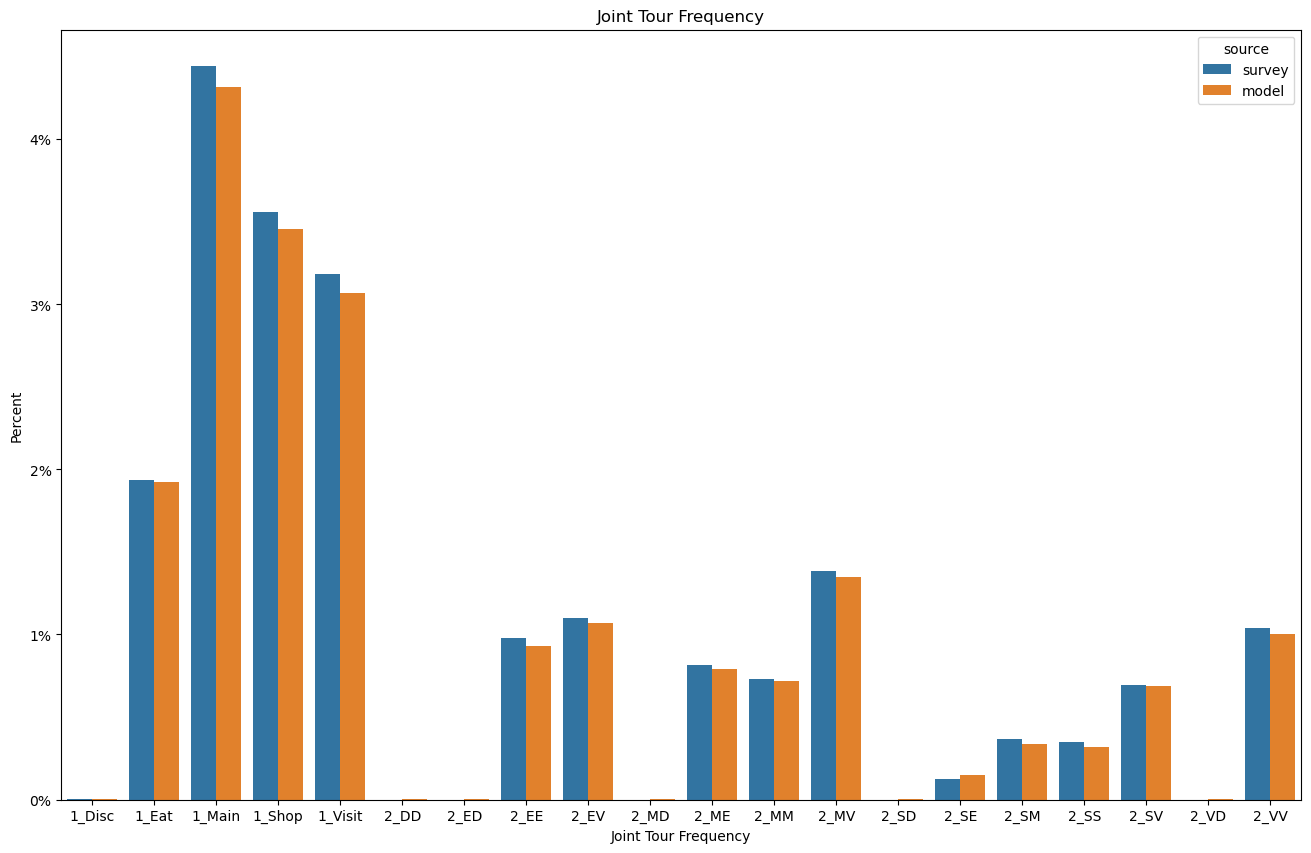

In [6]:
plot_data = pd.concat([jtfo[jtfo['joint_tour_frequency'] != '0_tours'][['joint_tour_frequency', 'ObsPct']].rename(columns = {'ObsPct': 'percent'}).assign(source = 'survey'),
    jtfo[jtfo['joint_tour_frequency'] != '0_tours'][['joint_tour_frequency', 'ModPct']].rename(columns = {'ModPct': 'percent'}).assign(source = 'model')
    ])

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot()
sns.barplot(data = plot_data, x = 'joint_tour_frequency', y = 'percent', hue = 'source')
plt.title(f"Joint Tour Frequency")
# plt.xticks(fontsize=16, rotation = 90)
# plt.yticks(fontsize=16)
plt.ylabel('Percent')
plt.xlabel('Joint Tour Frequency')
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0%}'))

plt.show()

In [7]:
new_coefs = asim_config[~asim_config['jtfPurp'].isna()].merge(jtfo[['joint_tour_frequency', 'new_coef']], left_on = 'jtfPurp', right_on = 'joint_tour_frequency')
#new_coefs['new_value'] = 
new_coefs[['coefficient_name', 'new_coef', 'constrain']].to_csv(sys.stdout, index = False)

coefficient_name,new_coef,constrain
coef_asc_0_tours,4.4067,F
coef_asc_1_Shop,-0.0687,F
coef_asc_1_Main,0.3309,F
coef_asc_1_Eat,-0.7859,F
coef_asc_1_Visit,0.1825,F
coef_asc_1_Disc,-7.1128,F
asc_calib_2_SS,-5.3718,F
asc_calib_2_SM,-5.0253,F
asc_calib_2_SE,-6.1881,F
asc_calib_2_SV,-4.1425,F
asc_calib_2_SD,-10.0,F
asc_calib_2_MM,-4.3552,F
asc_calib_2_ME,-4.0977,F
asc_calib_2_MV,-3.2645,F
asc_calib_2_MD,-10.0,F
asc_calib_2_EE,-4.0982,F
asc_calib_2_EV,-3.555,F
asc_calib_2_ED,-10.0,F
asc_calib_2_VV,-3.4717,F
asc_calib_2_VD,-10.0,F
asc_calib_2_DD,-10.0,F
